Cycles
======

The [cycles](api/ktk.cycles.rst) module allows detecting cycles in TimeSeries, time-normalize these cycles and select the most repeatable ones.

In this tutorial, we will load kinetics data from wheelchair propulsion using a csv file, and then manipulate propulsion cycles.

In [1]:
import ktk.lab as ktk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the instrumented wheel's csv file
filename = 'data/pushrimkinetics/sample_sw_csvtxt.csv'

ts = ktk.pushrimkinetics.read_file(filename, file_format='smartwheel')
ts.data

{
         'Angle': <array of shape (7777,)>,
      'Channels': <array of shape (7777, 6)>,
        'Forces': <array of shape (7777, 4)>,
         'Index': <array of shape (7777,)>,
       'Moments': <array of shape (7777, 4)>
}

At this point, we have a TimeSeries that contains several signals, including forces and moments.

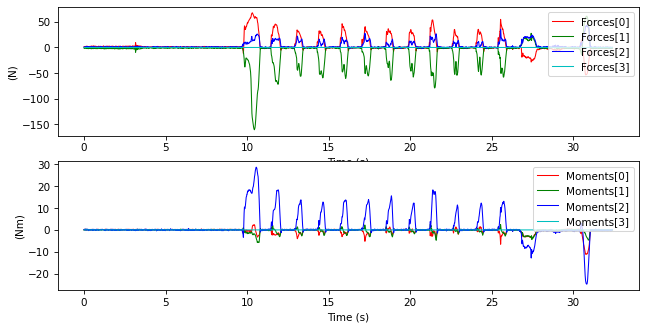

In [2]:
plt.subplot(2, 1, 1)
ts.plot('Forces')
plt.subplot(2, 1, 2)
ts.plot('Moments')

Detecting cycles
----------------

The [ktk.cycles.detect_cycles](api/ktk.cycles.rst#ktk.cycles.detect_cycles) allows detecting cycles in a TimeSeries, using a signal from this TimeSeries.

Here, to detect the cycles in these data, we will add a third data, the total force (Ftot) as the basis for cycle detection.

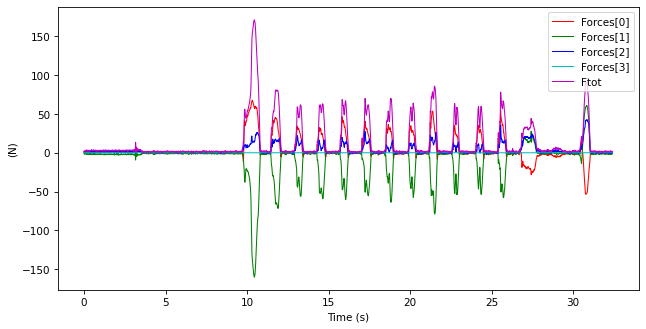

In [3]:
ts.data['Ftot'] = np.sqrt(np.sum(ts.data['Forces'] ** 2, 1))
ts.plot(['Forces', 'Ftot'])

Now let see how detecting cycles works. We will define the threshold values visually based on the figure above.

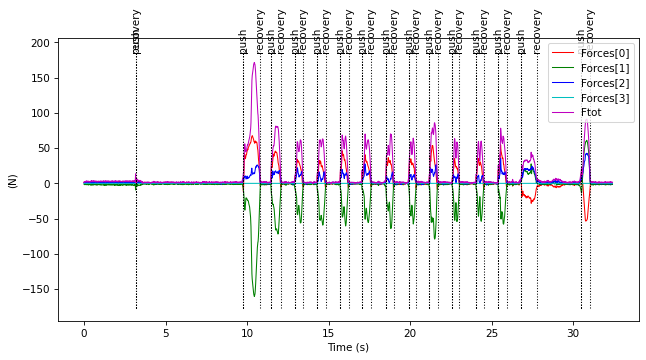

In [4]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_name1='push',
                                event_name2='recovery',
                                threshold1=10,
                                threshold2=5)
test.plot(['Forces', 'Ftot'])

We observe that a short cycle was wrongly during the first spike, which is not a push but a synchronization spike. We can reject those too short cycles by specifying minimal durations for both phases.

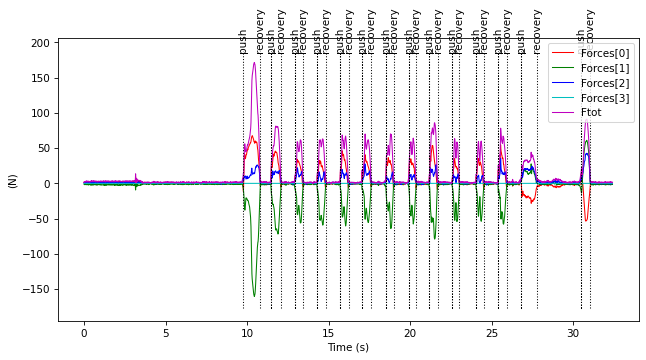

In [5]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_name1='push',
                                event_name2='recovery',
                                threshold1=10,
                                threshold2=5,
                                min_duration1=0.2,
                                min_duration2=0.2)
test.plot(['Forces', 'Ftot'])

We also see that the detected cycles at the end are different: the force components are not similar because those pushes are braking pushes instead of propulsion pushes. While the last one will be difficult to remove automatically, we could remove the first braking push by using a height value for the push phase (a value that should be reached during the phase).

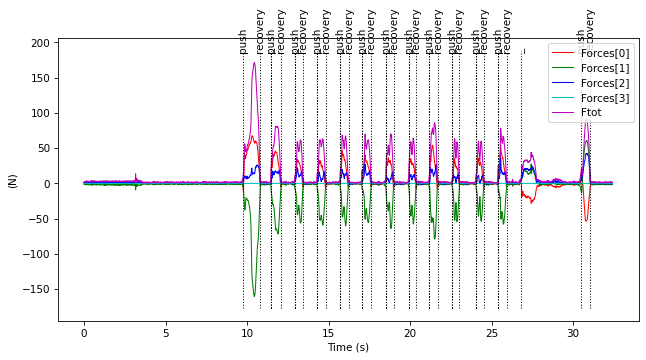

In [6]:
ts_with_events = ktk.cycles.detect_cycles(ts, 'Ftot',
                                          event_name1='push',
                                          event_name2='recovery',
                                          threshold1=10,
                                          threshold2=5,
                                          min_duration1=0.2,
                                          min_duration2=0.2,
                                          cross_height1=50)
ts_with_events.plot(['Forces', 'Ftot'])

We observe a `_` event at about 27 seconds. There are such `_` events at the end of each cycle. As a matter of fact, each detected cycle starts with  `event_name1`, transitions to the other phase with `event_name2` and ends with `_`.

Time-normalizing cycles
-----------------------

Once the cycles have been detected, we can time-normalize these cycles using [ktk.cycles.time_normalize()](api/ktk.cycles.rst#ktk.cycles.time_normalize) to get them on the same time scale (a percentage of the cycle). Each of the 12 complete cycles is then time-normalized from 0 to 100%, with cycles being multiples of 100%.

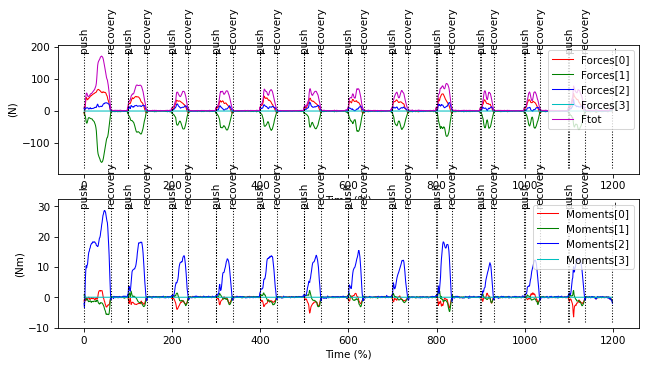

In [7]:
ts_normalized_on_cycle = ktk.cycles.time_normalize(ts_with_events, 'push', '_')
plt.subplot(2,1,1)
ts_normalized_on_cycle.plot(['Forces', 'Ftot'])
plt.subplot(2,1,2)
ts_normalized_on_cycle.plot('Moments')

To time-normalize only during the push phase, we define the cycle end as `recovery` instead of `_`. Each of the **13** complete pushes is then normalized from 0 to 100% of the push.

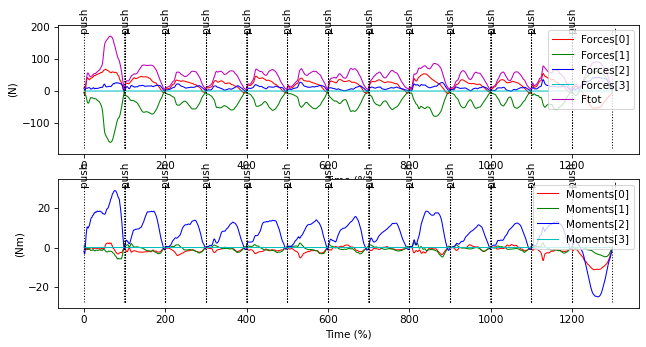

In [8]:
ts_normalized_on_push = ktk.cycles.time_normalize(ts_with_events, 'push', 'recovery')
plt.subplot(2,1,1)
ts_normalized_on_push.plot(['Forces', 'Ftot'])
plt.subplot(2,1,2)
ts_normalized_on_push.plot('Moments')

Combining the cycles
--------------------
Time-normalizing cycles is often performed in the aim of performing further operations (e.g., computing and visualizing the average cycle). Therefore, the next logical step is often to group the cycles into indexable arrays. This is done using the [ktk.cycles.stack](api/ktk.cycles.rst#ktk.cycles.stack) function.

In this example, we will stack the data from the last computed TimeSeries.

In [9]:
data = ktk.cycles.stack(ts_normalized_on_push)
data

{
         'Angle': <array of shape (13, 100)>,
      'Channels': <array of shape (13, 100, 6)>,
        'Forces': <array of shape (13, 100, 4)>,
          'Ftot': <array of shape (13, 100)>,
         'Index': <array of shape (13, 100)>,
       'Moments': <array of shape (13, 100, 4)>
}

The first dimension of each dictionary's entry corresponds to the cycles. It becomes easier to perform operations on cycles. For example, we could want to plot the propulsive moment `Mz` (Moments[2]) in each cycle one of top of the other:

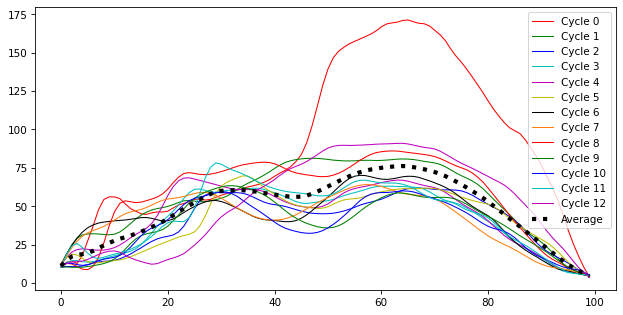

In [10]:
# Plot every cycles
for i_cycle in range(13):
    plt.plot(data['Ftot'][i_cycle], label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Ftot'], axis=0),
    'k:', linewidth=4, label="Average")

plt.legend()
plt.show()

Finding the most repeatable cycles
----------------------------------

In the previous step, we calculated an average cycle. However, this average cycle was calculated on cycles that were very different. We can use the [ktk.cycles.most_repeatable_cycles()](api/ktk.cycles.rst#ktk.cycles.most_repeatable_cycles) function to obtain an ordered list from the most repeatable cycles to the most different one. Here, we will base this analysis on the `Ftot` signal.

In [11]:
index = ktk.cycles.most_repeatable_cycles(data['Ftot'])
index                             

[9, 10, 2, 3, 5, 11, 4, 6, 7, 1, 8, 12, 0]

We see that cycles 12 (last) and 0 (first) were expectedly found as the least repeatable pushes. Now let's make the same plot of `Mz`, but based only on the five most repeatable cycles.

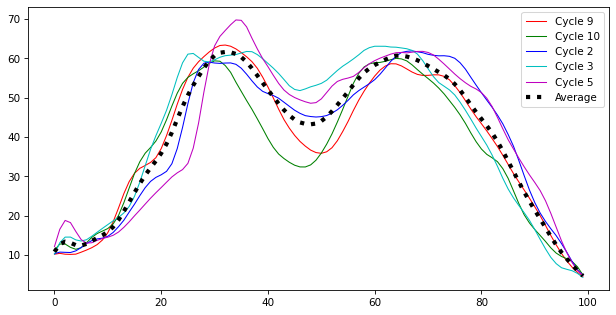

In [12]:
# Plot every cycles
for i_cycle in index[0:5]:
    plt.plot(data['Ftot'][i_cycle], label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Ftot'][index[0:5]], axis=0),
    'k:', linewidth=4, label="Average")

plt.legend()
plt.show()

For more information on cycles, please check the [API Reference for module cycles](api/ktk.cycles.rst).